In [2]:
# === LIBRARY IMPORTS (already done once, skip if imported earlier) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import community as community_louvain

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


In [3]:
# === STEP 1: Load and Preprocess Blelham Data ===
df = pd.read_csv("./DataSets/Blelham Tarn/BLEL_data_1945_2013.csv")
df = df[df["variable"].isin(["TEMP", "OXYG", "SECC", "NO3N", "NH4N", "PO4P", "TOTP"])].copy()

df["Date"] = pd.to_datetime(df["sdate"], dayfirst=True, errors="coerce")
df.dropna(subset=["Date", "value"], inplace=True)
df["Date"] = df["Date"].dt.to_period("M").dt.to_timestamp("M")

# Pivot to wide format: one row per month, variables as columns
monthly_all = df.pivot_table(index="Date", columns="variable", values="value", aggfunc="mean")
monthly_all.rename(columns={
    "TEMP": "Surface Temperature",
    "OXYG": "Surface Oxygen",
    "SECC": "Secchi Depth",
    "NO3N": "Nitrate",
    "NH4N": "Ammonium",
    "PO4P": "Phosphate",
    "TOTP": "Total Phosphorus"
}, inplace=True)

# === STEP 2: Restrict to 1978–2005 ===
monthly_all = monthly_all.loc["1978-01":"2005-12"].copy()
print("✅ Forcing matrix shape:", monthly_all.shape)
print("✅ Columns:", monthly_all.columns.tolist())
print("✅ Date range:", monthly_all.index.min(), "→", monthly_all.index.max())

✅ Forcing matrix shape: (330, 7)
✅ Columns: ['Ammonium', 'Nitrate', 'Surface Oxygen', 'Phosphate', 'Secchi Depth', 'Surface Temperature', 'Total Phosphorus']
✅ Date range: 1978-01-31 00:00:00 → 2005-12-31 00:00:00


/var/folders/jh/4dsp7k0j5257kvfjxfbt8jl00000gn/T/ipykernel_8483/594599744.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["sdate"], dayfirst=True, errors="coerce")


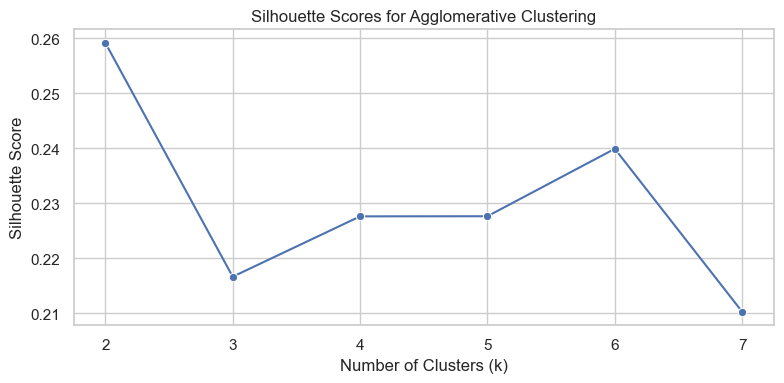

✅ Best number of clusters based on silhouette score: k = 2


In [4]:
# === Step 3: Clustering ===
# Drop missing rows before clustering
X = monthly_all.dropna()
X_scaled = StandardScaler().fit_transform(X)

# Silhouette scores
sil_scores = {}
for k in range(2, min(8, len(X_scaled))):  # k = 2 to 7
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X_scaled)
    if len(set(labels)) > 1:
        sil_scores[k] = silhouette_score(X_scaled, labels)

# Plot Silhouette Scores
plt.figure(figsize=(8, 4))
sns.lineplot(x=list(sil_scores.keys()), y=list(sil_scores.values()), marker='o')
plt.title("Silhouette Scores for Agglomerative Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Fit final model
if sil_scores:
    best_k = max(sil_scores, key=sil_scores.get)
    print(f"✅ Best number of clusters based on silhouette score: k = {best_k}")
    monthly_all.loc[X.index, "Cluster"] = AgglomerativeClustering(n_clusters=best_k).fit_predict(X_scaled)
else:
    print("⚠️ No valid clustering result found.")




/var/folders/jh/4dsp7k0j5257kvfjxfbt8jl00000gn/T/ipykernel_8483/2743103224.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")
/var/folders/jh/4dsp7k0j5257kvfjxfbt8jl00000gn/T/ipykernel_8483/2743103224.py:34: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/datascience_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


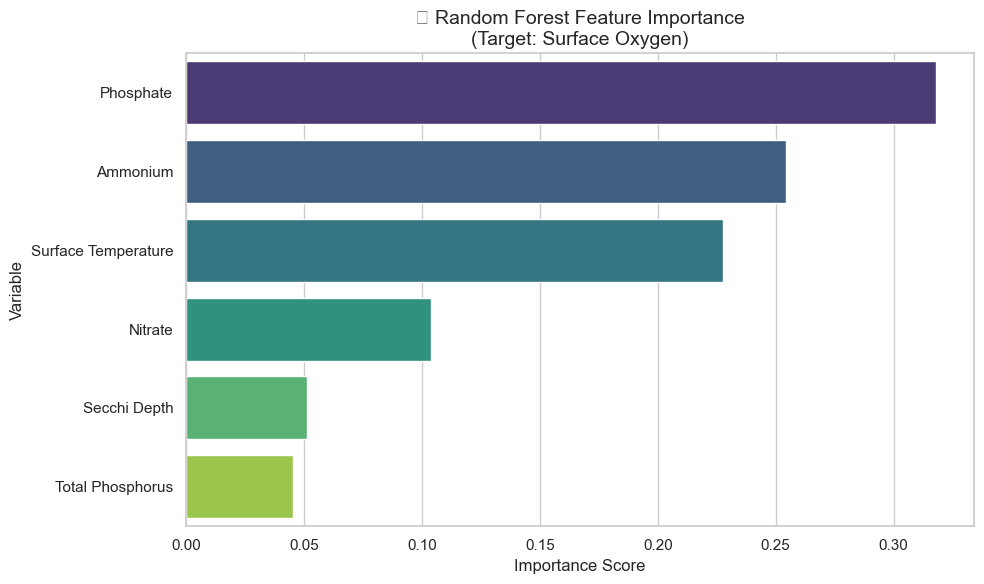

In [8]:
# === Step 3A: Prepare Features and Target ===

target_col = "Surface Oxygen"

# Drop target and any derived columns (e.g. 'Cluster' if present)
X = monthly_all.drop(columns=[target_col, "Cluster"], errors='ignore')
y = monthly_all[target_col]

# Drop rows with NaNs in X or y
rf_df = pd.concat([X, y], axis=1).dropna()
X_clean = rf_df.drop(columns=[target_col])
y_clean = rf_df[target_col]

# === Step 3B: Scale Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled_df = pd.DataFrame(X_scaled, index=X_clean.index, columns=X_clean.columns)

# === Step 3C: Run Random Forest Regressor ===
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_scaled_df, y_clean)

# === Step 3D: Feature Importances ===
importances = pd.Series(rf.feature_importances_, index=X_clean.columns).sort_values(ascending=False)

# === Step 3E: Plot ===
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("🌿 Random Forest Feature Importance\n(Target: Surface Oxygen)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [10]:
# === Step 5: Interpret Clusters Seasonally ===
# Assign human-readable seasonal cluster names
label_map = {
    0: "Cool Season (Spring/Winter-like)",
    1: "Warm Season (Summer/Autumn-like)"
}
monthly_all["Cluster_Label"] = monthly_all["Cluster"].map(label_map)

In [12]:

# === Step 1: Select variables for cosine similarity ===
X_cosine = monthly_all[[
    'Ammonium', 'Nitrate', 'Phosphate', 'Surface Temperature',
    'Surface Oxygen', 'Secchi Depth', 'Total Phosphorus'
]]

# === Step 2: Drop rows with NaNs to avoid cosine similarity errors ===
X_cosine_clean = X_cosine.dropna()

# === Step 3: Match monthly_all to filtered index (ensures graph node alignment) ===
monthly_all = monthly_all.loc[X_cosine_clean.index]

# === Step 4: Standardize ===
X_scaled_cosine = StandardScaler().fit_transform(X_cosine_clean)

# === Step 5: Cosine similarity + thresholding ===
cos_sim = cosine_similarity(X_scaled_cosine)
cos_sim[cos_sim < 0.85] = 0  # retain only strong edges

# === Step 6: Create Graph with labeled nodes ===
G = nx.from_numpy_array(cos_sim)
label_index = monthly_all.index.strftime('%Y-%m')
G = nx.relabel_nodes(G, dict(enumerate(label_index)))

# === Step 7: Louvain community detection ===
partition = community_louvain.best_partition(G)
monthly_all["Louvain"] = monthly_all.index.strftime('%Y-%m').map(partition)

# === Step 8: Summary ===
print(f"✅ Graph G: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"✅ Louvain communities detected: {len(set(partition.values()))}")



✅ Graph G: 258 nodes, 1395 edges
✅ Louvain communities detected: 26


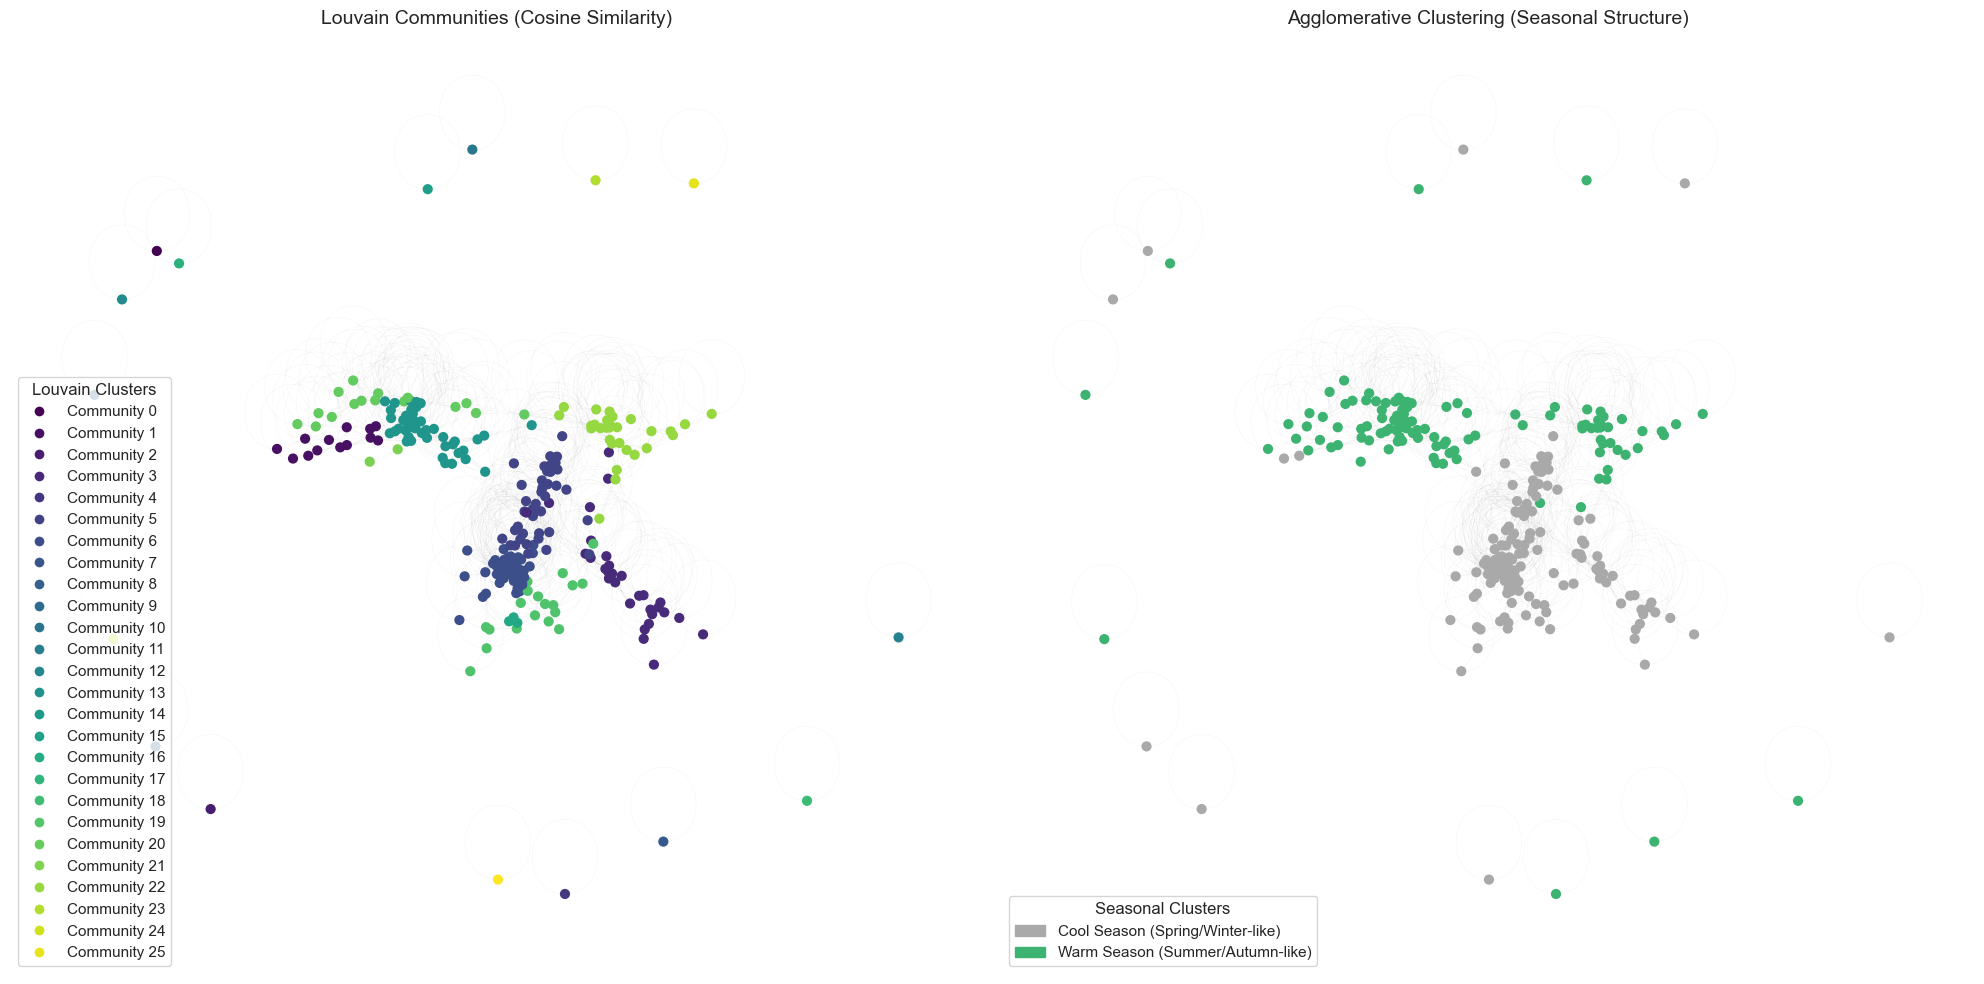

In [14]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# === Step 1: Setup position layout for consistency ===
pos = nx.spring_layout(G, seed=42)

# === Step 2: Color encodings ===
# Louvain communities (categorical codes)
louvain_codes = monthly_all["Louvain"].astype("category").cat.codes

# Seasonal clusters (Cluster_Label) as interpretable colors
cluster_labels = monthly_all["Cluster_Label"]
cluster_palette = {
    "Cool Season (Spring/Winter-like)": "#a9a9a9",   # Gray
    "Warm Season (Summer/Autumn-like)": "#3cb371",   # MediumSeaGreen
}
cluster_colors = cluster_labels.map(cluster_palette)

# === Step 3: Plot ===
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# LEFT PANEL — Louvain
nx.draw_networkx_edges(G, pos, alpha=0.05, edge_color="black", width=0.3, ax=axes[0])
nx.draw_networkx_nodes(G, pos, node_color=louvain_codes, node_size=40, cmap="viridis", ax=axes[0])
axes[0].set_title("Louvain Communities (Cosine Similarity)", fontsize=14)
axes[0].axis("off")

# Add legend for Louvain clusters (categorical numbers)
n_louvain = monthly_all["Louvain"].nunique()
louvain_handles = [
    Line2D([0], [0], marker='o', color='w',
           label=f'Community {i}', markerfacecolor=plt.cm.viridis(i/n_louvain), markersize=8)
    for i in range(n_louvain)
]
axes[0].legend(handles=louvain_handles, title="Louvain Clusters", loc="lower left", frameon=True)

# RIGHT PANEL — Agglomerative Clustering
nx.draw_networkx_edges(G, pos, alpha=0.05, edge_color="black", width=0.3, ax=axes[1])
nx.draw_networkx_nodes(G, pos, node_color=cluster_colors, node_size=40, ax=axes[1])
axes[1].set_title("Agglomerative Clustering (Seasonal Structure)", fontsize=14)
axes[1].axis("off")

# Add legend for seasonal cluster colors
season_handles = [
    mpatches.Patch(color=color, label=label)
    for label, color in cluster_palette.items()
]
axes[1].legend(handles=season_handles, title="Seasonal Clusters", loc="lower left", frameon=True)

plt.tight_layout()
plt.show()


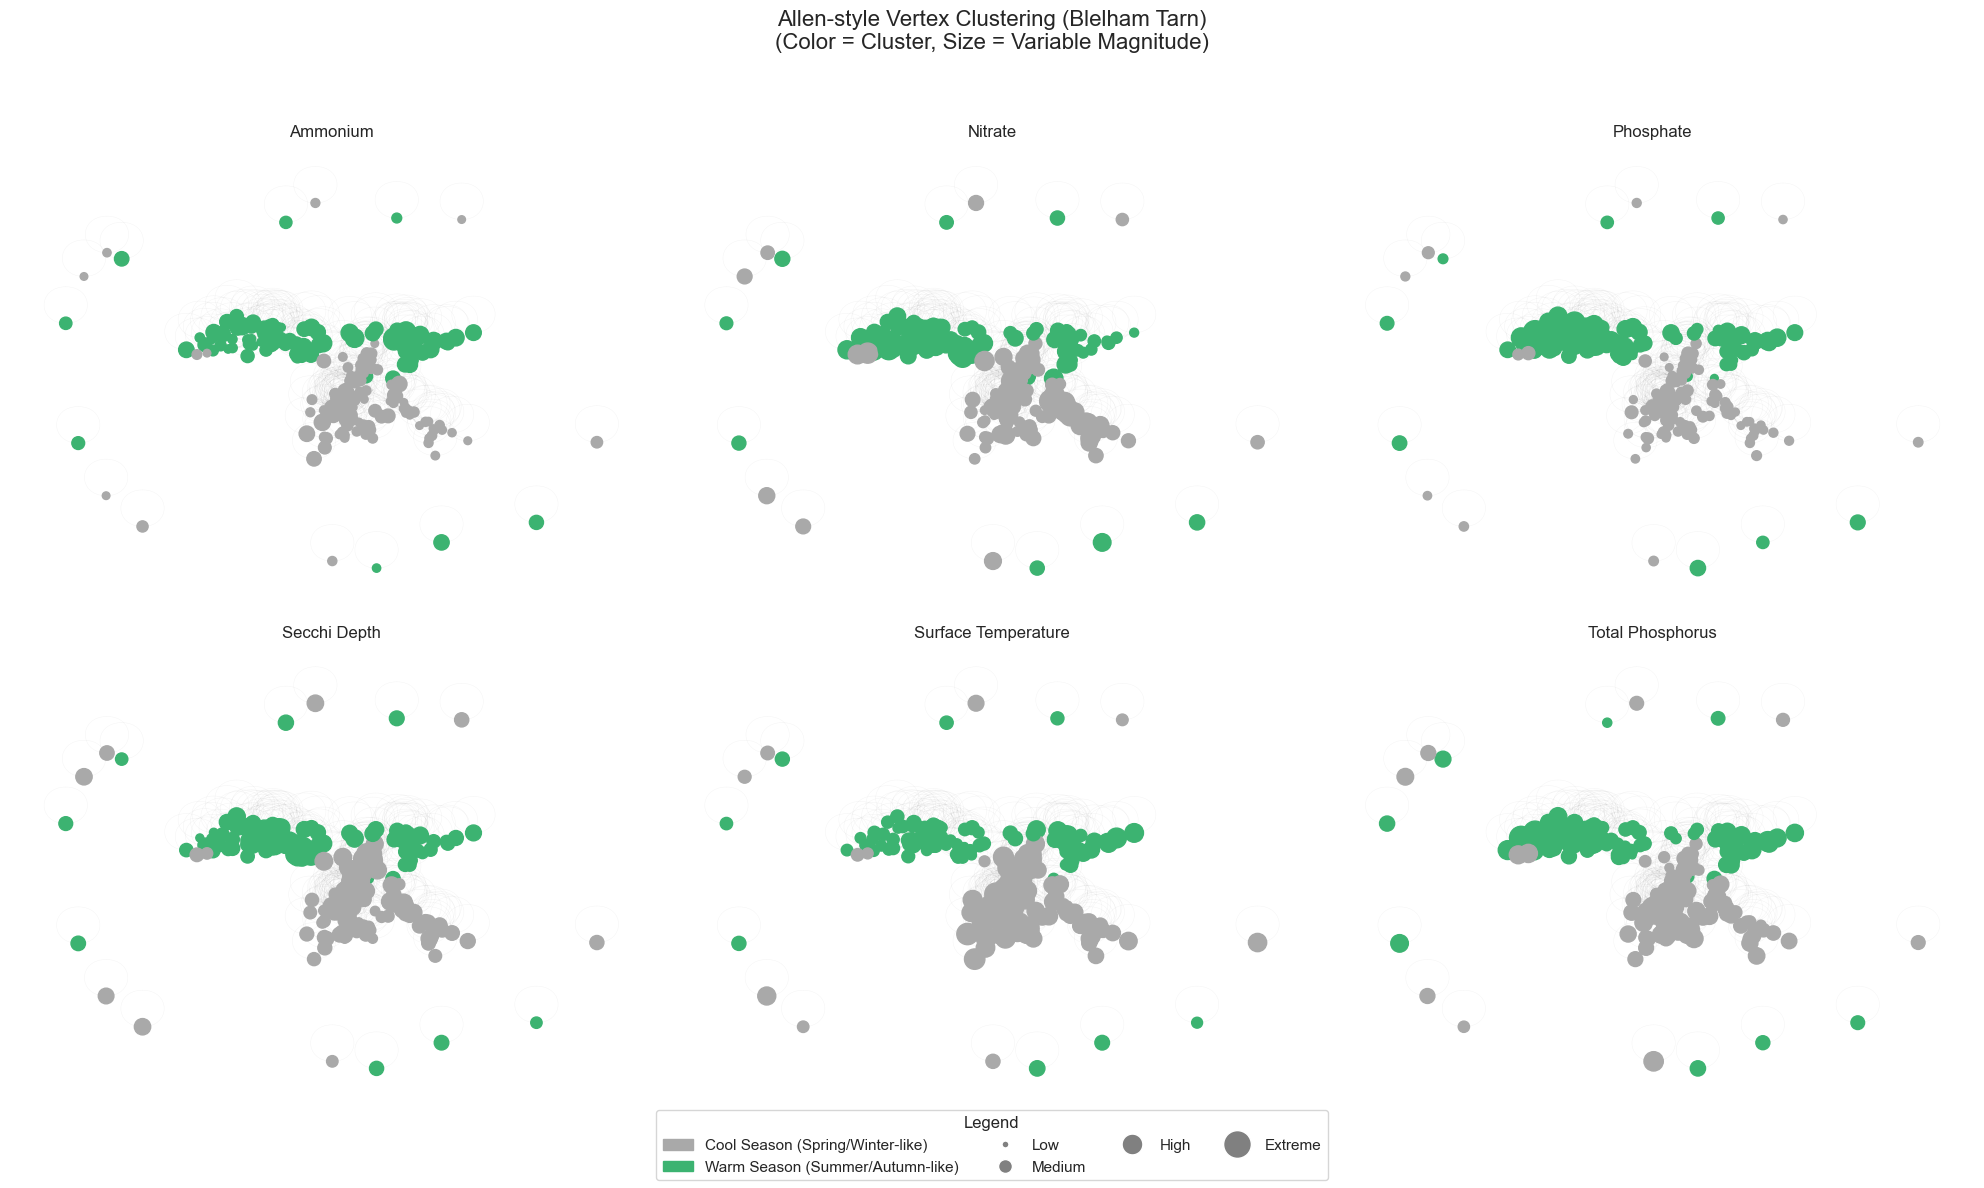

In [16]:
# === Vertex Clustering Panels (Blelham Tarn) ===
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Ensure monthly_all index matches the graph node labels ('YYYY-MM')
monthly_all = monthly_all.copy()
monthly_all["Label"] = monthly_all.index.strftime("%Y-%m")
monthly_all = monthly_all.set_index("Label")

variables = ['Ammonium', 'Nitrate', 'Phosphate', 'Secchi Depth', 'Surface Temperature', 'Total Phosphorus']
n_panels = len(variables)

# Reuse node layout
pos = nx.spring_layout(G, seed=42)
node_labels = list(G.nodes())

# Get cluster colors
cluster_palette = {
    "Cool Season (Spring/Winter-like)": "#a9a9a9",   # Gray
    "Warm Season (Summer/Autumn-like)": "#3cb371",   # MediumSeaGreen
}
cluster_colors = monthly_all["Cluster_Label"].map(cluster_palette)

# === Create Subplots ===
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]

    # Normalize node size based on variable value
    node_sizes = monthly_all.loc[node_labels, var].fillna(0)
    scaled_sizes = (node_sizes - node_sizes.min()) / (node_sizes.max() - node_sizes.min())
    scaled_sizes = scaled_sizes * 250 + 30

    nx.draw_networkx_edges(G, pos, alpha=0.04, edge_color="black", width=0.4, ax=ax)
    nx.draw_networkx_nodes(
        G,
        pos,
        node_color=cluster_colors.loc[node_labels],
        node_size=scaled_sizes,
        ax=ax
    )
    ax.set_title(var)
    ax.axis("off")

# === Create legend ===
# Cluster colors
season_legend = [
    mpatches.Patch(color=color, label=label) for label, color in cluster_palette.items()
]

# Size legend (based on size scaling)
size_legend = [
    Line2D([0], [0], marker='o', color='w', label='Low', markersize=5, markerfacecolor='gray'),
    Line2D([0], [0], marker='o', color='w', label='Medium', markersize=10, markerfacecolor='gray'),
    Line2D([0], [0], marker='o', color='w', label='High', markersize=15, markerfacecolor='gray'),
    Line2D([0], [0], marker='o', color='w', label='Extreme', markersize=20, markerfacecolor='gray'),
]

# Final panel layout
fig.legend(handles=season_legend + size_legend, loc="lower center", ncol=4, title="Legend", frameon=True)
fig.suptitle("Allen-style Vertex Clustering (Blelham Tarn)\n(Color = Cluster, Size = Variable Magnitude)", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()



In [17]:
# === Cluster Summary Statistics ===

# Select only relevant variables
summary_vars = [
    "Ammonium", "Nitrate", "Phosphate", "Surface Temperature",
    "Surface Oxygen", "Secchi Depth", "Total Phosphorus"
]

# Group by Cluster_Label and compute mean
summary = monthly_all.groupby("Cluster_Label")[summary_vars].mean().round(2)

# Add number of months per cluster
summary["Months"] = monthly_all["Cluster_Label"].value_counts().reindex(summary.index)

# Reset index for display
summary = summary.reset_index()

# Display
print("✅ Cluster Summary Table:")
display(summary)


✅ Cluster Summary Table:


variable,Cluster_Label,Ammonium,Nitrate,Phosphate,Surface Temperature,Surface Oxygen,Secchi Depth,Total Phosphorus,Months
0,Cool Season (Spring/Winter-like),28.12,556.34,1.53,14.12,100.41,2.23,29.90,148
1,Warm Season (Summer/Autumn-like),83.15,776.91,6.89,6.65,81.97,2.43,28.28,110
